# SciPy minimizers and constraints

The `Minuit` class can call SciPy minimizers implemented in `scipy.optimize.minimize` as alternatives to the standard Migrad minimizer to minimize the cost function. The SciPy minimizers may perform better or worse on some problems. You can give them a try when you are not satisfied with Migrad.

More importantly, the SciPy minimizers support additional features that Migrad lacks.

* Migrad does not allow one to use an externally computed hessian matrix.
* Migrad does not allow one to use additional constraints of the form $\vec a \leq f(\vec x) \leq \vec b$ in the minimization, where $\vec x$ is the parameter vector of length $m$, $f$ is an arbitrary function $\mathcal{R}^m \rightarrow \mathcal{R}^k$ and $\vec a, \vec b$ are vector bounds with length $k$.

SciPy comes with a variety of minimization algorithms and some of them support these features. The ability to use constraints is interesting for HEP applications. In particular, it allows us to ensure that a pdf as a function of the parameters is always positive. This can be ensured sometimes with suitable limits on the parameters, but not always.

We demonstrate this on a common example of fit of an additive model with a signal and background pdf.

In [1]:
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import numpy as np
from numba_stats import norm_pdf, norm_cdf
import matplotlib.pyplot as plt
from scipy.interpolate import BPoly
from IPython.display import display

The signal pdf is a Gaussian, the background is modelled with second degree Bernstein polynomials. We perform an extended maximum likelihood fit, where the full density model is given by the sum of the signal and background component.

In [2]:
xrange = (0, 1)


def model(x, b0, b1, b2, sig, mu, sigma):
    bc = np.array((b0, b1, b2))[:, np.newaxis]
    b = BPoly(bc, xrange)
    bint = b.integrate(*xrange)
    sint = sig * np.diff(norm_cdf(xrange, mu, sigma))[0]
    return bint + sint, b(x) + sig * norm_pdf(x, mu, sigma)

In searches for rare decays, it is common to fit models like this to small simulated samples that contain only background.

We run one such fit. For simplicity, the mean and width of the Gaussian is fixed, only the signal amplitude and the background parameters are fitted.

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -293.1                     │              Nfcn = 118              │
│ EDM = 3.68e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0    │    27     │    20     │            │            │    0    │         │       │
│ 1 │ b1    │    100    │    40     │            │            │    0    │         │       │
│ 2 │ b2    │    25     │    20     │            │            │    0    │         │       │
│ 3 │ sig   │    -1     │     4     │            │            │         │         │       │
│ 4 │ mu    │   0.500   │   0.005   │            │            │         │         │  yes  │
│ 5 │ sigma │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────┐
│       │       b0       b1       b2      sig       mu    sigma │
├───────┼───────────────────────────────────────────────────────┤
│    b0 │      385     -522      158       20        0        0 │
│    b1 │     -522 1.67e+03     -567    -90.6        0        0 │
│    b2 │      158     -567      418     22.4        0        0 │
│   sig │       20    -90.6     22.4     14.9        0        0 │
│    mu │        0        0        0        0        0        0 │
│ sigma │        0        0        0        0        0        0 │
└───────┴───────────────────────────────────────────────────────┘

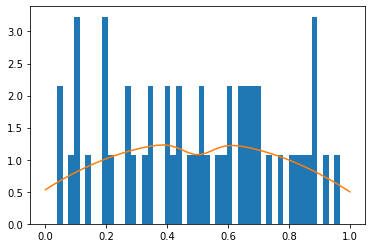

In [12]:
rng = np.random.default_rng(2)
x = rng.uniform(0, 1, size=50)

cost = ExtendedUnbinnedNLL(x, model)

m = Minuit(cost, b0=25, b1=25, b2=25, sig=0.1, mu=0.5, sigma=0.05)
m.print_level = 0
m.limits["b0", "b1", "b2"] = (0, None)
m.fixed["mu", "sigma"] = True
display(m.migrad())

plt.hist(x, bins=50, density=True)
xm = np.linspace(0, 1)
yint, ym = model(xm, *m.values)
plt.plot(xm, ym / yint);

We see in this example that the signal amplitude can come out negative. This happens if the background has an underfluctuation where the signal is expected. This is not an issue if the sum of signal and background is still positive everywhere where we evaluate it.

There are, however, no restrictions in this setting that prevent the sum of signal and background from becoming negative, which is mathematically forbidden. If this happens, it leads to a breakdown of the fit (taking logarithm of a negative number will cause havoc). We apply the fit many times on randomly sampled background-only data to observe this.

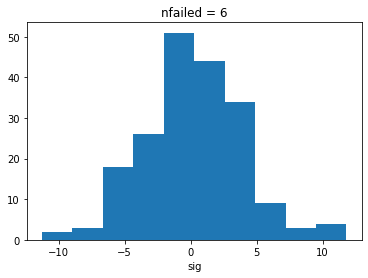

In [16]:
rng = np.random.default_rng(1)

sigs_migrad = []
nfailed = 0
for itry in range(200):
    cost.data = rng.uniform(0, 1, size=len(cost.data))
    m.reset()
    m.migrad()
    if m.valid:
        sigs_migrad.append(m.values["sig"])
    else:
        nfailed += 1
    
plt.title(f"nfailed = {nfailed}")
plt.hist(sigs_migrad)
plt.xlabel("sig");

The distribution of the signal amplitude looks fairly gaussian which is good, but the fit failed to converge in a few cases due to the problem just described. Simply discarding these cases is not acceptable, it would distort conclusions drawn from this distribution, which is commonly needed to set limits or to compute the p-value for an observed amplitude.

We can repair this by placing a limit on the signal amplitude. This is a suitable solution, but some people dislike this, since this distribution is then no longer normal.

An alternative is to perform a constrained minimization, which allows us to directly add a condition to the fit that the model density must be positive at each data point. We merely need to replace the call `m.migrad` with the call `m.scipy` and pass the (non-linear) constraint. An appropriate algorithm is automatically selected which performs a constrained minimization. The SciPy minimizers are fully integrated into Minuit, which means that Minuit computes an EDM value for the minimum and parameter uncertainties.

We run SciPy with the constraint on the same simulated samples on which we ran Migrad before.

┌─────────────────────────────────────────────────────────────────────────┐
│                             SciPy[SLSQP]                                │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -294.1                     │              Nfcn = 185              │
│ EDM = 2.48e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b0    │    62     │    22     │            │            │    0    │         │       │
│ 1 │ b1    │    70     │    40     │            │            │    0    │         │       │
│ 2 │ b2    │    22     │    18     │            │            │    0    │         │       │
│ 3 │ sig   │    -1     │     4     │            │            │         │         │       │
│ 4 │ mu    │   0.500   │   0.005   │            │            │         │         │  yes  │
│ 5 │ sigma │  50.0e-3  │  0.5e-3   │            │            │         │         │  yes  │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────────┐
│       │       b0       b1       b2      sig       mu    sigma │
├───────┼───────────────────────────────────────────────────────┤
│    b0 │      477     -438      116     10.7        0        0 │
│    b1 │     -438 1.26e+03     -409    -69.6        0        0 │
│    b2 │      116     -409      311     16.4        0        0 │
│   sig │     10.7    -69.6     16.4     13.2        0        0 │
│    mu │        0        0        0        0        0        0 │
│ sigma │        0        0        0        0        0        0 │
└───────┴───────────────────────────────────────────────────────┘

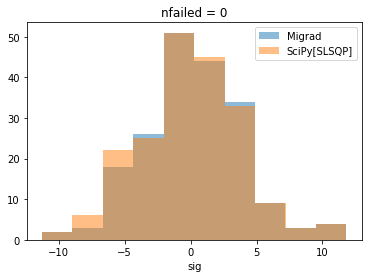

In [17]:
from scipy.optimize import NonlinearConstraint

rng = np.random.default_rng(1)

sigs_scipy = []
nfailed = 0
for itry in range(200):
    cost.data = rng.uniform(0, 1, size=len(cost.data))
    m.reset()
    # constraint to ensure that the density is positive at all values of x
    m.scipy(constraints=NonlinearConstraint(lambda *par: model(x, *par)[1], 1e-100, np.inf))
    if m.valid:
        sigs_scipy.append(m.values["sig"])
    else:
        nfailed += 1

display(m)

plt.title(f"nfailed = {nfailed}")
plt.hist(sigs_migrad, alpha=0.5, label="Migrad")
plt.hist(sigs_scipy, alpha=0.5, label=m.fmin.algorithm)
plt.xlabel("sig")
plt.legend();

There are no failures this time. We see some difference between the distributions produced by Migrad and SciPy. 

Some deviations are caused by bin-migration due to the finite resolution of the fitted values (Migrad by default stops the fit well before the accuracy reaches machine precision to save time).

More important is the loss in the lower tail of the distribution, where Migrad did not converge and samples are missing which are included in the distribution produced by the SciPy minimizer.